# Find weather stations that set flags
From the AWS data catalog of station data, find the subset of weather stations that set flags 
<br>Output a DataFrame

In [2]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## 1. Define some helper functions

In [3]:
def find_flags(station_ds):
    """Find unique flags in a Dataset.
    Filters through flag variables; assumes flag variables contain the substring '_eraqc'

    Parameters
    ----------
    station_ds: xr.Dataset
        Dataset containing station data, with each variable as a unique data variable

    Returns
    -------
    unique_flags: list or None
        List of unique flag values found in station_ds
        Returns None if no flags found for any variable

    """

    # Get the string names of the eraqc flag variables
    era_flag_var_names = [var for var in station_ds.data_vars if "_eraqc" in var]

    # Subset Dataset to just contain flag variables
    station_flags_ds = station_ds[era_flag_var_names]

    # Check for nulls in the flag variables
    # If all are null, that means the station set no flags for this event!
    all_null = station_flags_ds.to_array().isnull().all().item()
    unique_flags = None

    # If there are some flags set, find out what they are
    if not all_null:
        # Stack all the variables, since we don't care which variables the flags belong to
        # Makes it easier to search the array (fewer lines of code :)
        # Works like np.flatten, but on an xarray object
        stacked = station_flags_ds.to_array().stack(
            {"everything": ["variable", "time"]}
        )

        # Drop all non-null values
        # i.e. [nan, nan, 23, nan, 17] --> [23, 17]
        all_flags = stacked.where(~stacked.isnull(), drop=True)

        # Get unique flag values as integers
        # nan is treated as a float so the .isnull() step converted floats to ints (I think)
        # i.e. [23.0, 23.0, 23.0, 17.0, 23.0, 19.0, 19.0] --> [23, 17, 19]
        unique_flags = list(np.unique(all_flags.values).astype(int))

    return unique_flags

## 2. Read in county shapefile and station metadata csv
County shapefile is used for getting event geometry <br>Station metadata is used to get the station ids to read in station data from the S3 bucket

In [4]:
# Read in a list of weather stations
# We just use the names of the stations to filter
# Ideally I'd like to see this moved to the AWS bucket
train_stns = pd.read_csv("../data/qaqc_training_station_list.csv")

# Create new geometry column from lat and lon columns
# This will enable us to filter through the GeoDataFrame using our county geometry
train_stns = gpd.GeoDataFrame(
    train_stns,
    geometry=gpd.points_from_xy(
        train_stns.longitude, train_stns.latitude, crs="EPSG:4326"
    ),
)

In [5]:
# Read in county shapefiles from S3
ca_counties = gpd.read_file(
    "s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp"
)
ca_counties = ca_counties.to_crs(train_stns.crs)  # Convert to station CRS
# ca_counties.head()

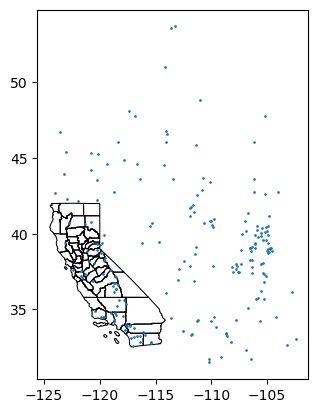

In [6]:
# Plot all the stations and all the counties
# This is a check to ensure both have the same projection
fig, ax = plt.subplots()
ca_counties.boundary.plot(color="black", ax=ax, linewidth=0.75, zorder=10)
train_stns.geometry.plot(markersize=0.9, ax=ax, zorder=15);

## 3. Set your event date and (optional) event geometry
For example, lets use the 2007 Santa Ana winds october 19 to November 16, 2007

In [33]:
event_start_date = "2007-10-19"
event_end_date = "2007-11-16"

# Focusing on a subset of the impacted counties to speed up the notebook and for illustration purposes
event_counties = [
    # "San Diego",
    # "Los Angeles",
    "Ventura",
    "Santa Barbara",
    # "San Bernardino",
    # "Orange",
    # "Riverside",
]
event_geom = ca_counties[ca_counties["NAME"].isin(event_counties)]  # Get event geometry

## 4. Get the stations that intersect the event geometry

In [29]:
train_stns["intersects"] = train_stns.intersects(
    event_geom.unary_union
)  # See which stations intersect with the event polygon
event_stns = train_stns[train_stns["intersects"] == True].reset_index(
    drop=True
)  # Get just those stations, drop the others
event_stns

,era-id,elevation,network,longitude,latitude,geometry,intersects
0,CNRFC_TCTC1,2900.0,CNRFC,-119.90880,34.52080,POINT (-119.90880 34.52080),True
1,CWOP_C7260,430.0,CWOP,-120.42267,34.88400,POINT (-120.42267 34.88400),True
2,RAWS_CEEC1,1707.0,RAWS,-118.71956,34.18657,POINT (-118.71956 34.18657),True
3,CNRFC_LLDC1,1160.0,CNRFC,-118.69030,34.30210,POINT (-118.69030 34.30210),True
4,CNRFC_ECIC1,3458.0,CNRFC,-119.63750,34.48278,POINT (-119.63750 34.48278),True
5,RAWS_TR155,7743.0,RAWS,-118.98117,34.76731,POINT (-118.98117 34.76731),True
6,CWOP_AV377,3970.0,CWOP,-119.71317,34.49467,POINT (-119.71317 34.49467),True


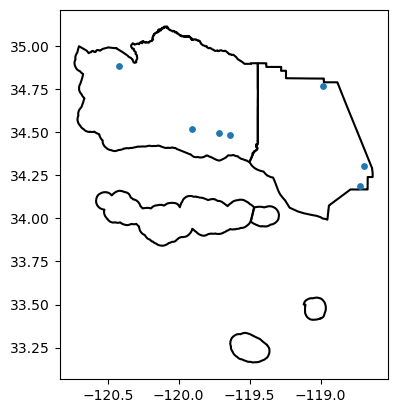

In [30]:
# Make a plot to visualize the stations and event poly
fig, ax = plt.subplots()
event_geom.boundary.plot(color="black", ax=ax, zorder=10)
event_stns.geometry.plot(markersize=15, ax=ax, zorder=15);

## 5. Filter through stations to see if flags were set

In [31]:
# Flags, network, and station ID will be stored here
# Dictionary can be easily convered to a DataFrame and output as a csv
stations_with_flags = {"network": [], "era-id": [], "flags": []}

# Loop through each station to look for flags
for i in tqdm(range(len(event_stns))):
    # Get info for one station
    network_name, station_id = event_stns.iloc[i][["network", "era-id"]]

    station_ds = xr.open_zarr(f"s3://wecc-historical-wx/3_qaqc_wx/{network_name}/{station_id}.zarr").compute()

    # Reduce dimension of object
    # "station" is a singleton dimension
    station_ds = station_ds.squeeze()

    # Subset Dataset to event time period
    station_ds = station_ds.sel(time=slice(event_start_date, event_end_date))

    # Look for flags
    # If no flags found, find_flags returns None
    unique_flags = find_flags(station_ds)

    # If flags are found, save them to the dictionary
    if unique_flags is not None:
        stations_with_flags["network"].append(network_name)
        stations_with_flags["era-id"].append(station_id)
        stations_with_flags["flags"].append(unique_flags)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


In [32]:
# Output a DataFrame
# Note: No record which variables these flags belong to
stations_with_flags_df = pd.DataFrame(stations_with_flags)
stations_with_flags_df

,network,era-id,flags
0,CWOP,CWOP_C7260,"[13, 14, 15, 27, 28]"
1,RAWS,RAWS_CEEC1,"[14, 15, 35]"
